# Cabecera

## Trabajo de curso: Recomendador de Revistas
**Asignatura:** Ciencia de Datos en Ingeniería  
**Autor:** Santiago Santana Martínez  
**Fecha:** 29 de diciembre de 2025
**Entorno:** Jupyter Notebook (Python 3)

## Objetivo del proyecto

...

# Introducción

En este trabajo se aborda el problema de recomendación de revistas científicas como una tarea de clasificación supervisada de documentos. A partir del título, resumen y palabras clave de un artículo, el sistema predice la revista más adecuada para su publicación. En esta primera parte se emplean técnicas clásicas de procesamiento del lenguaje natural y aprendizaje automático.

In [1]:
import json
import glob
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

# Carga de los JSON

Los artículos se almacenan en formato JSON, uno por revista y año. Cada entrada contiene el título, resumen, palabras clave y la revista asociada, que se utilizará como etiqueta de clase.

In [57]:
def load_json_folder(folder_path):
    articles = []
    for file in glob.glob(os.path.join(folder_path, "*.json")):
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
            articles.extend(data)
    return articles

In [58]:
base_path = "Revistas RAW"

all_articles = []
for journal_folder in os.listdir(base_path):
    folder = os.path.join(base_path, journal_folder)
    if os.path.isdir(folder):
        all_articles.extend(load_json_folder(folder))

print(f"Número total de artículos: {len(all_articles)}")

Número total de artículos: 18066


# Construcción del DataFrame df

Cada artículo se representa como un único documento textual concatenando título, abstract y keywords. Esta decisión permite capturar tanto la información temática general como los términos específicos del dominio.

In [59]:
rows = []

for art in all_articles:
    text_parts = [
        art.get("title", ""),
        art.get("abstract", ""),
        " ".join(art.get("keywords", []))
    ]
    text = " ".join(text_parts)

    rows.append({
        "text": text,
        "journal": art["journal"],
        "year": int(art["year"])
    })

df = pd.DataFrame(rows)
df.head()

,text,journal,year
0,Comparing SNNs and RNNs on neuromorphic vision...,Neural Networks,2020
1,Hybrid tensor decomposition in neural network ...,Neural Networks,2020
2,Exploiting bi-directional global transition pa...,Neural Networks,2020
3,On the robustness of skeleton detection agains...,Neural Networks,2020
4,MGAT: Multi-view Graph Attention Networks Mult...,Neural Networks,2020


## Preprocesamiento de los datos

### Detección de posibles valores perdidos

In [60]:
print("=" * 60)
print("DETECCIÓN DE VALORES PERDIDOS")
print("=" * 60)

missing_in_cols = df.isnull().sum()
print("\nValores nulos por columna:")
print(missing_in_cols)

total_missing = df.isnull().sum().sum()
print(f"\nTotal de valores nulos: {total_missing}")

porcentaje_nulos = (df.isnull().sum() / len(df) * 100).round(2)
print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos)

missing_in_rows = df.isnull().any(axis=1).sum()
print(f"\nFilas con al menos un valor nulo: {missing_in_rows}")

if total_missing == 0:
    print("\n No hay valores perdidos en el dataset.")
else:
    print(f"\n Hay {total_missing} valores perdidos que requieren tratamiento.")

DETECCIÓN DE VALORES PERDIDOS

Valores nulos por columna:
text       0
journal    0
year       0
dtype: int64

Total de valores nulos: 0

Porcentaje de valores nulos por columna:
text       0.0
journal    0.0
year       0.0
dtype: float64

Filas con al menos un valor nulo: 0

 No hay valores perdidos en el dataset.


### Normalización de la columna "journal"

Se establecen una serie de abreviaciones para los nombres de las revistas, de este modo se evitan posibles errores por confusión con los nombres y se facilita la representación gráfica.

In [61]:
journal_abbrev = {
    "Artificial Intelligence in the Age of Neural Networks and Brain Computing": "AI-NNBC",
    "Artificial Neural Networks for Renewable Energy Systems and Real-World Applications": "ANN-RE",
    "Expert Systems with Applications": "ESA",
    "Expert Systems with Applications: X": "ESA-X",
    "Intelligent Fractal-Based Image Analysis": "IFIA",
    "Machine Learning and Pattern Recognition Methods in Chemistry from Multivariate and Data Driven Modeling": "MLPR-C",
    "Memristive Devices for Brain-Inspired Computing": "MDBIC",
    "Neural Networks": "NN",
    "Pattern Recognition": "PR",
    "Pattern Recognition Letters": "PRL",
    "Robotics and Autonomous Systems": "RAS",
    "State of the Art in Neural Networks and Their Applications": "SOTA-NN"
}

df["journal"] = df["journal"].str.strip()
df["journal"] = df["journal"].map(journal_abbrev)

### Visualización de la distribución de artículos por revista

Mostrar gráficamente los artículos por cada revista para detectar una posible situación de desbalanceo mediante una simple inspección visual.

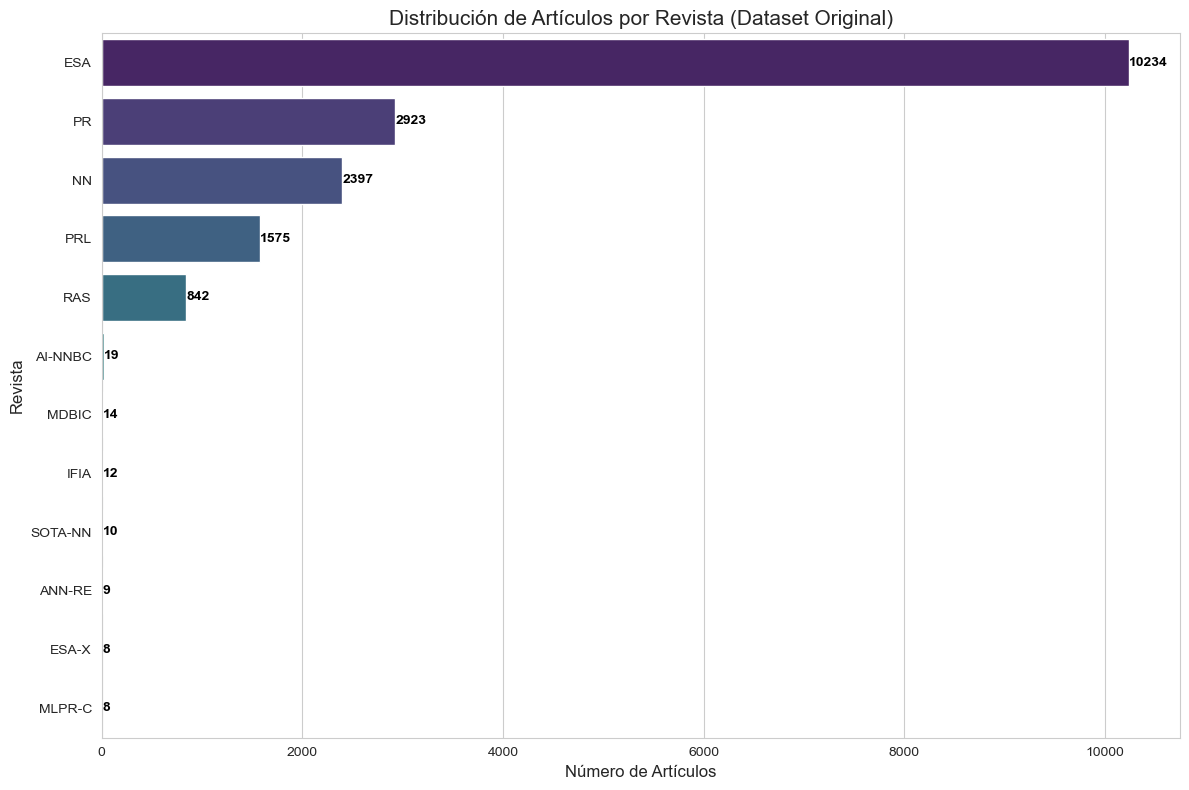

In [62]:
def plot_journal_distribution(journal_counts):

    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    sns.barplot(x=journal_counts.values, y=journal_counts.index, hue=journal_counts.index, palette='viridis', legend=False)

    plt.title('Distribución de Artículos por Revista (Dataset Original)', fontsize=15)
    plt.xlabel('Número de Artículos', fontsize=12)
    plt.ylabel('Revista', fontsize=12)

    for i, v in enumerate(journal_counts.values):
        plt.text(v + 3, i, str(v), color='black', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

journal_counts = df['journal'].value_counts()
plot_journal_distribution(journal_counts)

### Problema de desbalanceo

Dada la naturaleza del corpus recolectado, se ha detectado un fuerte desequilibrio entre las categorías. Para evitar que el clasificador ignore las revistas con menor volumen de publicaciones, se ha aplicado un filtro de soporte mínimo. Esta decisión de diseño permite trabajar con un dataset más equilibrado y estadísticamente significativo, mejorando la fiabilidad de las recomendaciones finales.

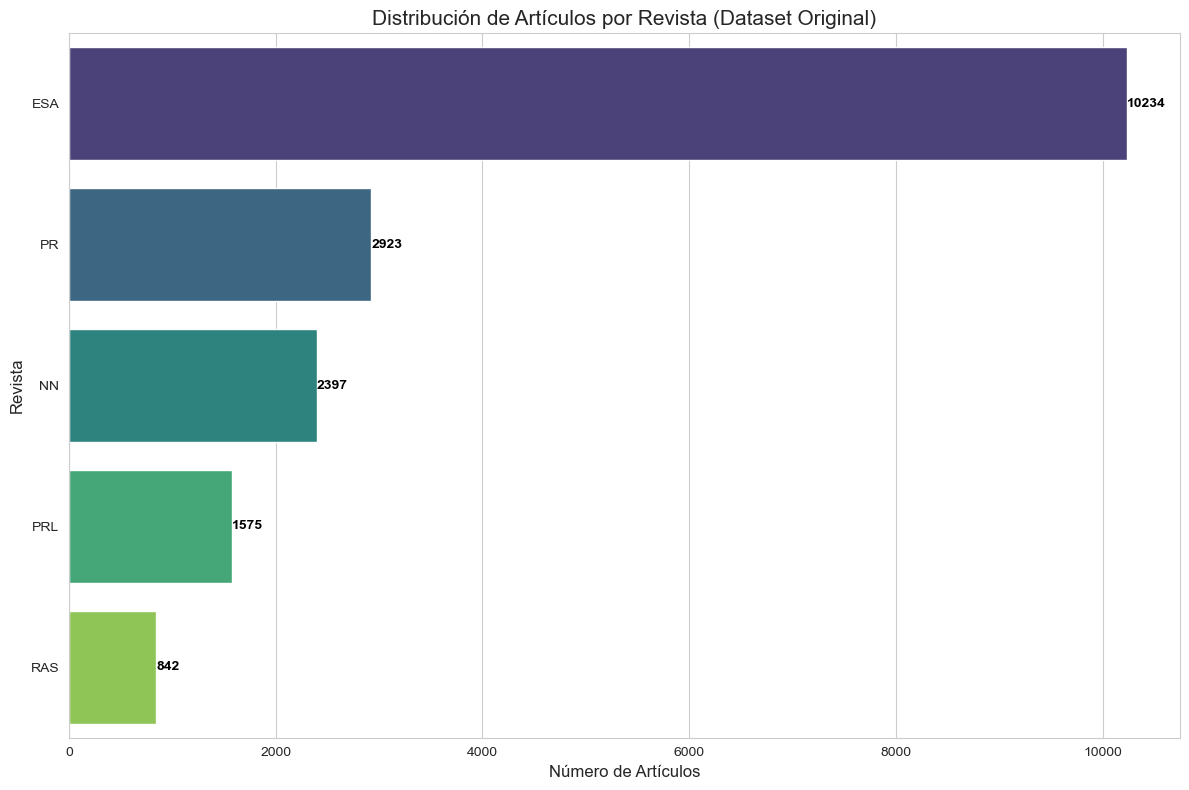

In [ ]:
MIN_SAMPLES_PER_JOURNAL = 20
df = df[df['journal'].isin(journal_counts[journal_counts >= MIN_SAMPLES_PER_JOURNAL].index)]

plot_journal_distribution(df['journal'].value_counts())

# División del conjunto de datos

El conjunto de datos se divide en entrenamiento (80%) y test (20%) de forma estratificada por revista.
El conjunto de test se reserva exclusivamente para la evaluación final y no se utiliza durante el proceso de validación cruzada.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["journal"],
    test_size=0.2,
    random_state=42,
    stratify=df["journal"]
)

# Configuración de la validación cruzada

Para evaluar de forma robusta el rendimiento de los modelos se emplea validación cruzada estratificada de 5 particiones sobre el conjunto de entrenamiento, utilizando métricas macro para evitar sesgos debidos al desbalanceo entre revistas.

In [65]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro"
}

In [66]:
def print_cv_results(results, model_name):
    print(f"\n===== {model_name} (Cross-Validation) =====")
    for key in results:
        if key.startswith("test_"):
            values = results[key]
            metric = key.replace("test_", "")
            print(f"{metric}: {values.mean():.4f} ± {values.std():.4f}")

# Modelos clásicos usando TF-IDF

**TF-IDF (Term Frequency-Inverse Document Frequency)** es una técnica que convierte texto en números que los algoritmos de aprendizaje automático pueden procesar:

- **TF (Term Frequency):** Cuenta cuántas veces aparece cada palabra en un documento. Palabras frecuentes son más importantes.
- **IDF (Inverse Document Frequency):** Penaliza palabras que aparecen en muchos documentos (como "the", "and"). Palabras únicas a ciertos documentos son más valiosas.
- **Resultado:** Cada documento se representa como un vector numérico donde cada número refleja la importancia de una palabra en ese documento específico.

In [67]:
pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipeline_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

pipeline_rf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

## Validación cruzada de los modelos

In [68]:
results_lr = cross_validate(
    pipeline_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
results_svm = cross_validate(
    pipeline_svm, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
results_rf = cross_validate(
    pipeline_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)

print_cv_results(results_lr, "Logistic Regression + TF-IDF")
print_cv_results(results_svm, "Linear SVM + TF-IDF")
print_cv_results(results_rf, "Random Forest + TF-IDF")


===== Logistic Regression + TF-IDF (Cross-Validation) =====
accuracy: 0.6789 ± 0.0096
precision: 0.5808 ± 0.0070
recall: 0.6384 ± 0.0107
f1: 0.6035 ± 0.0088

===== Linear SVM + TF-IDF (Cross-Validation) =====
accuracy: 0.7124 ± 0.0118
precision: 0.6097 ± 0.0125
recall: 0.6080 ± 0.0098
f1: 0.6063 ± 0.0113

===== Random Forest + TF-IDF (Cross-Validation) =====
accuracy: 0.6857 ± 0.0057
precision: 0.6842 ± 0.0189
recall: 0.4711 ± 0.0085
f1: 0.5069 ± 0.0097


# Modelos clásicos con lemmatización (NLTK) y TF-IDF

En esta variante se incorpora un preprocesado adicional basado en lematización con NLTK, con el objetivo de reducir la variabilidad morfológica de las palabras y evaluar su impacto en el rendimiento de los modelos.

In [69]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Lematización de textos

La lematización reduce las palabras a su forma raíz (lema). Por ejemplo, "running", "runs" y "ran" se transforman todas en "run". 

Este proceso:
1. **Tokeniza** el texto en palabras individuales
2. **Lematiza** cada palabra a su forma base
3. **Filtra** stop words (palabras comunes sin significado: "the", "a", "is")
4. **Mantiene** solo palabras alfabéticas

El objetivo es reducir la variabilidad del lenguaje y mejorar el rendimiento del modelo al normalizar formas diferentes de la misma palabra.

In [70]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and tok not in stop_words
    ]
    return " ".join(tokens)

X_train_lem = X_train.apply(lemmatize_text)
X_test_lem  = X_test.apply(lemmatize_text)

## Pipelines con lematización

In [71]:
pipeline_lr_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipeline_svm_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

pipeline_rf_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

## Validación cruzada con lematización

In [72]:
results_lr_lem = cross_validate(
    pipeline_lr_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

results_svm_lem = cross_validate(
    pipeline_svm_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

results_rf_lem = cross_validate(
    pipeline_rf_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print_cv_results(results_lr_lem, "Logistic Regression + Lemmatization")
print_cv_results(results_svm_lem, "Linear SVM + Lemmatization")
print_cv_results(results_rf_lem, "Random Forest + Lemmatization")


===== Logistic Regression + Lemmatization (Cross-Validation) =====
accuracy: 0.6761 ± 0.0091
precision: 0.5775 ± 0.0078
recall: 0.6352 ± 0.0101
f1: 0.6002 ± 0.0089

===== Linear SVM + Lemmatization (Cross-Validation) =====
accuracy: 0.7085 ± 0.0109
precision: 0.6040 ± 0.0112
recall: 0.6013 ± 0.0126
f1: 0.6000 ± 0.0120

===== Random Forest + Lemmatization (Cross-Validation) =====
accuracy: 0.6821 ± 0.0048
precision: 0.6979 ± 0.0198
recall: 0.4599 ± 0.0069
f1: 0.4949 ± 0.0074


# Entrenamiento final del modelo y evaluación en test

En esta fase, cada modelo se entrena utilizando la totalidad del conjunto de entrenamiento, sin validación cruzada, con el objetivo de maximizar la información disponible antes de la evaluación final.

### Sin lematización

In [73]:
pipeline_lr.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

print("Modelos entrenados.")

Modelos entrenados.


### Con lematización

In [74]:
pipeline_lr_lem.fit(X_train_lem, y_train)
pipeline_svm_lem.fit(X_train_lem, y_train)
pipeline_rf_lem.fit(X_train_lem, y_train)

print("Modelos entrenados.")

Modelos entrenados.


## Evaluación cuantitativa en test

In [75]:
def evaluate_on_test(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"\n===== {model_name} - Test =====\n")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return y_pred

### Logistic Regression (sin lematización)

In [76]:
y_pred_lr = evaluate_on_test(
    pipeline_lr,
    X_test,
    y_test,
    "Logistic Regression (TF-IDF)"
)


===== Logistic Regression (TF-IDF) - Test =====

Accuracy: 0.6845618915159944
Classification Report:
              precision    recall  f1-score   support

         ESA       0.90      0.75      0.82      2047
          NN       0.57      0.65      0.61       480
          PR       0.49      0.61      0.54       585
         PRL       0.28      0.37      0.32       315
         RAS       0.70      0.85      0.77       168

    accuracy                           0.68      3595
   macro avg       0.59      0.64      0.61      3595
weighted avg       0.72      0.68      0.70      3595



### Linear SVM (sin lematización)

In [77]:
y_pred_svm = evaluate_on_test(
    pipeline_svm,
    X_test,
    y_test,
    "Linear SVM (TF-IDF)"
)


===== Linear SVM (TF-IDF) - Test =====

Accuracy: 0.7159944367176634
Classification Report:
              precision    recall  f1-score   support

         ESA       0.86      0.85      0.85      2047
          NN       0.59      0.58      0.59       480
          PR       0.51      0.59      0.55       585
         PRL       0.34      0.27      0.30       315
         RAS       0.76      0.81      0.78       168

    accuracy                           0.72      3595
   macro avg       0.61      0.62      0.61      3595
weighted avg       0.71      0.72      0.71      3595



### Random Forest (sin lematización)

In [78]:
y_pred_rf = evaluate_on_test(
    pipeline_rf,
    X_test,
    y_test,
    "Random Forest (TF-IDF)"
)


===== Random Forest (TF-IDF) - Test =====

Accuracy: 0.6812239221140473
Classification Report:
              precision    recall  f1-score   support

         ESA       0.69      0.94      0.80      2047
          NN       0.86      0.34      0.48       480
          PR       0.52      0.44      0.47       585
         PRL       0.65      0.05      0.09       315
         RAS       0.78      0.55      0.64       168

    accuracy                           0.68      3595
   macro avg       0.70      0.46      0.50      3595
weighted avg       0.69      0.68      0.63      3595



### Logistic Regression (con lematización)

In [79]:
y_pred_lr_lem = evaluate_on_test(
    pipeline_lr_lem,
    X_test_lem,
    y_test,
    "Logistic Regression (Lemmatization)"
)


===== Logistic Regression (Lemmatization) - Test =====

Accuracy: 0.6828929068150209
Classification Report:
              precision    recall  f1-score   support

         ESA       0.90      0.75      0.82      2047
          NN       0.55      0.64      0.60       480
          PR       0.48      0.62      0.54       585
         PRL       0.29      0.35      0.31       315
         RAS       0.70      0.85      0.77       168

    accuracy                           0.68      3595
   macro avg       0.58      0.64      0.61      3595
weighted avg       0.72      0.68      0.70      3595



### Linear SVM (con lematización)

In [80]:
y_pred_svm_lem = evaluate_on_test(
    pipeline_svm_lem,
    X_test_lem,
    y_test,
    "Linear SVM (Lemmatization)"
)


===== Linear SVM (Lemmatization) - Test =====

Accuracy: 0.7112656467315717
Classification Report:
              precision    recall  f1-score   support

         ESA       0.85      0.84      0.84      2047
          NN       0.59      0.56      0.58       480
          PR       0.51      0.59      0.55       585
         PRL       0.33      0.25      0.28       315
         RAS       0.76      0.82      0.79       168

    accuracy                           0.71      3595
   macro avg       0.61      0.61      0.61      3595
weighted avg       0.71      0.71      0.71      3595



### Random Forest (con lematización)

In [81]:
y_pred_rf_lem = evaluate_on_test(
    pipeline_rf_lem,
    X_test_lem,
    y_test,
    "Random Forest (Lemmatization)"
)


===== Random Forest (Lemmatization) - Test =====

Accuracy: 0.678442280945758
Classification Report:
              precision    recall  f1-score   support

         ESA       0.69      0.94      0.80      2047
          NN       0.89      0.33      0.48       480
          PR       0.50      0.44      0.47       585
         PRL       0.69      0.03      0.07       315
         RAS       0.81      0.50      0.62       168

    accuracy                           0.68      3595
   macro avg       0.72      0.45      0.49      3595
weighted avg       0.69      0.68      0.63      3595



## Matriz de Confusión

In [84]:
def plot_confusion_matrix(y_true, y_pred, labels, title,figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Matriz de confusión — Mejor modelo sin lematización

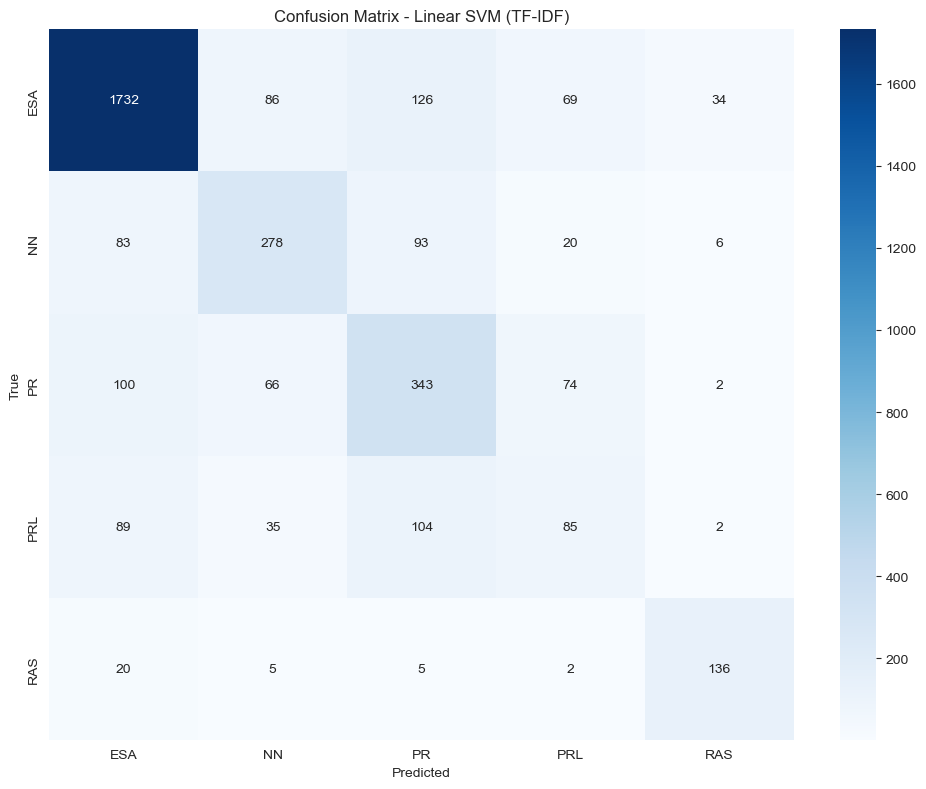

In [85]:
labels = sorted(df["journal"].unique())
plot_confusion_matrix(
    y_test,
    y_pred_svm,
    labels,
    "Confusion Matrix - Linear SVM (TF-IDF)"
)

### Matriz de confusión — Mejor modelo con lematización

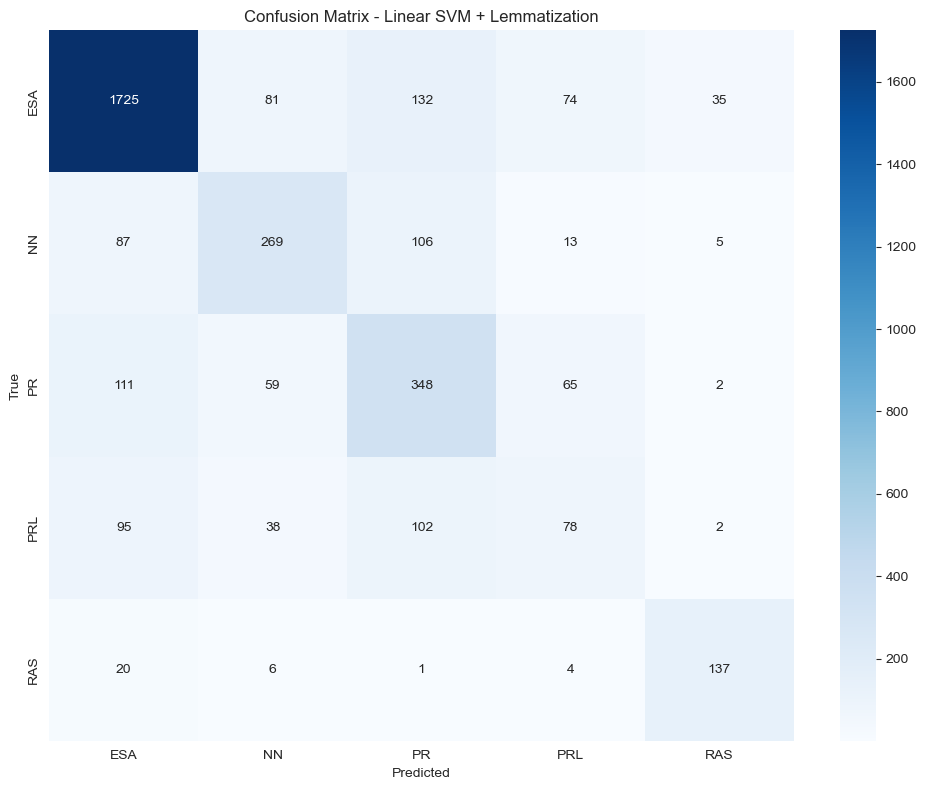

In [86]:
plot_confusion_matrix(
    y_test,
    y_pred_svm_lem,
    labels,
    "Confusion Matrix - Linear SVM + Lemmatization"
)